In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re, string, unicodedata
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobvoyles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
train = pd.read_csv('data/disaster_response_messages_training.csv')
print(len(train))
train.head()

21046


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [93]:
test = pd.read_csv('data/disaster_response_messages_test.csv')
print(len(test))
test.head()

2629


,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,9,test,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,39,test,We are at Gressier we needs assistance right a...,Se gressier nou an difikilte tanpri vin ede nou,direct,1,0,1,0,1,...,0,0,1,1,0,0,0,0,0,1
2,49,test,"Delmas 33 in Silo, need water.",Delma 33 silo gen problem dlo,direct,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,79,test,"SOS SOS, please provide police officers on the...",EMGENCY EMGENCY SI POLIS LA TE KA BAY PREZANS ...,direct,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,99,test,"I am a driver, a mechanic ,. I want to help","MWEN SE YON NMALIEN, CHOF, MEKANISYEN MWEN BEZ...",direct,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
train.isnull().sum()

id                            0
split                         0
message                       0
original                  12855
genre                         0
related                       0
PII                           0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops   

In [95]:
test.isnull().sum()

id                           0
split                        0
message                      0
original                  1623
genre                        0
related                      0
PII                          0
request                      0
offer                        0
aid_related                  0
medical_help                 0
medical_products             0
search_and_rescue            0
security                     0
military                     0
child_alone                  0
water                        0
food                         0
shelter                      0
clothing                     0
money                        0
missing_people               0
refugees                     0
death                        0
other_aid                    0
infrastructure_related       0
transport                    0
buildings                    0
electricity                  0
tools                        0
hospitals                    0
shops                        0
aid_cent

In [96]:
train.drop('original', axis=1, inplace=True)
test.drop('original', axis=1, inplace=True)

In [97]:
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [98]:
vocabulary = []
new_train = []
for text in train['message']:
    new_text = preprocess(text)
    #if(len(new_text) > 2):
    vocabulary.append(new_text)
    new_train.append(' '.join(new_text))

In [99]:
new_test = []
for text in test['message']:
    new_text = preprocess(text)
    #if(len(new_text) > 2):
    new_test.append(' '.join(new_text))

In [100]:
tokens = [item for sublist in vocabulary for item in sublist]
print(len(tokens))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

296334


['people',
 'water',
 'food',
 'help',
 'need',
 'please',
 'earthquake',
 'nt',
 'us',
 'like',
 'would',
 'said',
 'know',
 'also',
 'haiti',
 'areas',
 'one',
 'country',
 'government',
 'find',
 'sandy',
 'information',
 'relief',
 'aid',
 'good',
 'two',
 'health',
 'get',
 'area',
 'many',
 'affected',
 'thank',
 'children',
 'since',
 'new',
 'message',
 'work',
 'emergency',
 'million',
 'want',
 'tents',
 'give',
 'supplies',
 'go',
 'last',
 'power',
 'local',
 'region',
 'international',
 'well']

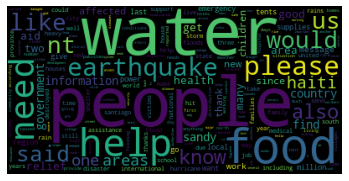

In [101]:
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [102]:
def predict(typeDisaster):
    final_train = pd.DataFrame(new_train,columns=['message'])
    final_train['id'] = train['id']
    final_train[typeDisaster] = train[typeDisaster]
    final_test = pd.DataFrame(new_test,columns=['message'])
    final_test['id'] = test['id']
    X_train = final_train.loc[:21046, 'message'].values
    y_train = final_train.loc[:21046, typeDisaster].values
    X_test = final_test.loc[:2629, 'message'].values
    y_true = test.loc[:2629, typeDisaster].values

    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    test_vectors = vectorizer.transform(X_test)
    clf = MultinomialNB().fit(train_vectors, y_train)
    
    predicted = clf.predict(test_vectors)
    output = pd.DataFrame({'id': test.id, typeDisaster : predicted})
    disaster.append(typeDisaster)
    accuracyScores.append(accuracy_score(y_true, predicted))

In [103]:
disaster = []
accuracyScores = []
    
for column in train.iloc[:,6:]:
    predict(column)
    
Finaldf = pd.DataFrame()   
Finaldf['Disaster']  = disaster
Finaldf['Accuracy Score']  = accuracyScores
Finaldf.sort_values(by=['Accuracy Score'], ascending=False)

,Disaster,Accuracy Score
8,child_alone,1.000000
22,tools,0.998479
24,shops,0.997337
30,fire,0.995816
25,aid_centers,0.994294
6,security,0.994294
14,missing_people,0.993914
23,hospitals,0.993153
5,search_and_rescue,0.989730
12,clothing,0.985926
